# An illustration of Theorem and Proposition 1
Here we simulate thermal noise currents and show that the problem is
equivalent to a deterministic problem
## Graph setup
Define graph and graph Laplacian

In [1]:
using Plots, LinearAlgebra, Test, Random, Statistics
⊗ = kron
Nx = 5; Ny = 5; # number of nodes
x = (0:(Nx-1))*ones(1,Ny)
y = ones(Nx)*((0:(Ny-1))')
D(N) = [ (i+1==j) - (i==j) for i=1:N-1,j=1:N]
# Discrete gradient
∇ = [ I(Ny) ⊗ D(Nx) # horizontal edges
      D(Ny) ⊗ I(Nx) # vertical edges
]
𝐁 = findall( (x[:].==0) .| (x[:].==Nx-1) .| (y[:].==0) .| (y[:].==Ny-1))
𝐈 = setdiff(1:Nx*Ny,𝐁)
n𝐈 =length(𝐈); n𝐁 = length(𝐁);
n𝐄, n𝐕 = size(∇)
R𝐈 = I(n𝐕)[𝐈,:]  # restriction to interior nodes
𝐈𝐈edges = [ i for (i, r) in enumerate(eachrow(∇)) if findall(abs.(r).>0) ⊆ 𝐈 ]'
edgemask = [i ∈ 𝐈𝐈edges for i ∈ 1:n𝐄]

f = (x[𝐁] .== Nx-1) + (y[𝐁] .== Ny-1) # boundary condition
σ = ones(n𝐄);

## Graph plotting

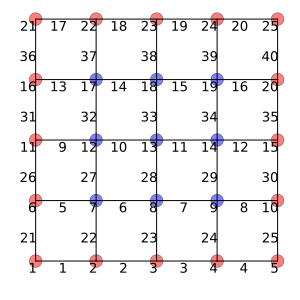

In [2]:
scatter(x[𝐈],y[𝐈], color="blue",markersize=7,markeralpha=0.5);
scatter!(x[𝐁],y[𝐁], color="red",markersize=7,markeralpha=0.5);
for i in eachindex(x)
  annotate!(x[i], y[i], text("$i",:black,:top,:right,9))
end
for (i, r) in enumerate(eachrow(∇))
  i1, i2 = findall(abs.(r) .> 0)
  plot!([x[i1], x[i2]], [y[i1], y[i2]], color="black", lw=1)
  annotate!((x[i1]+x[i2])/2, (y[i1]+y[i2])/2, text("$i", :black, :top,:right,9))
end
p=plot!(legend=:none, aspect_ratio=:equal, axis=false, grid=false,size=(300,300))

## Generate random noise currents
The code below stores all realizations so it is unnecessarily memory
intensive. Also notice that the factor $\kappa/\pi$ appears in both the
variance of the thermal noise currents and the end result. So instead of using
Boltzmann's constant $\kappa \approx 1.380649 \times 10^{−23}$ J/K we can use
$\kappa = \pi$ and any relative errors we calculate will be accurate. We also
chose a very small background temperature (1K) because it allowed for a more
accuarate result with fewer realizations.

relative error = 2.2888346879973582%


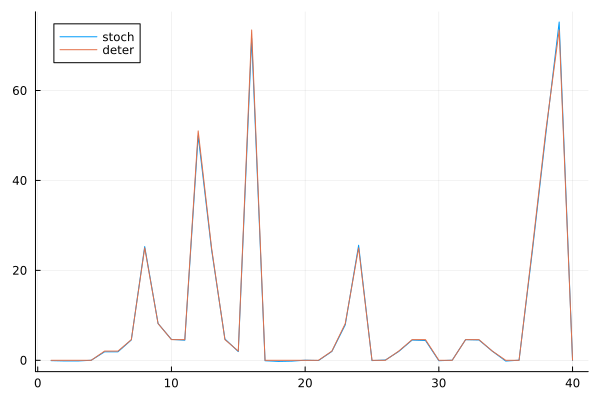

In [3]:
Random.seed!(17) # initialize seed
κ = π # the correct Boltzmann constant is κ = 1.380649e−23 # J/K
T0 = 1; δT = 100; # background temp and perturbation
Nrel = 10000; # number of realizations

L = ∇'*diagm(σ)*∇ # Laplacian
udet = zeros(n𝐕)
udet[𝐁] = f
udet[𝐈] = - L[𝐈,𝐈]\(L[𝐈,𝐁]*udet[𝐁])

# background temperature experiment
m0 = zeros(Nrel)
for k ∈ 1:Nrel
    Jstd = sqrt.((κ/π)*T0*σ)
    J0 = Jstd.*randn(n𝐄)
    u0𝐈 = L[𝐈,𝐈]\((∇'*J0)[𝐈])
    g0 = L[𝐁,𝐈]*u0𝐈
    m0[k] = f'*g0
end
fg0 = var(m0)

# perturbed experiment
me = zeros(n𝐄,Nrel)
for e ∈ 1:n𝐄
   Jstd = sqrt.((κ/π)*[(T0+δT*(j==e))*σ[j] for j=1:n𝐄])
   for k ∈ 1:Nrel
    Je = Jstd.*randn(n𝐄)
    ue𝐈 = L[𝐈,𝐈]\((∇'*Je)[𝐈])
    ge = L[𝐁,𝐈]*ue𝐈
    me[e,k] = f'*ge
   end
end
fge = var(me,dims=2)

stoch = fge .- fg0
deter = (δT*κ/π)*σ.*abs2.(∇*R𝐈'*R𝐈*udet)

rel_error = norm(stoch - deter)/norm(deter)
println("relative error = ", 100*rel_error,"%")

plot(stoch,label="stoch")
plot!(deter,label="deter")

## Plots of deterministic vs stochastic dissipated power

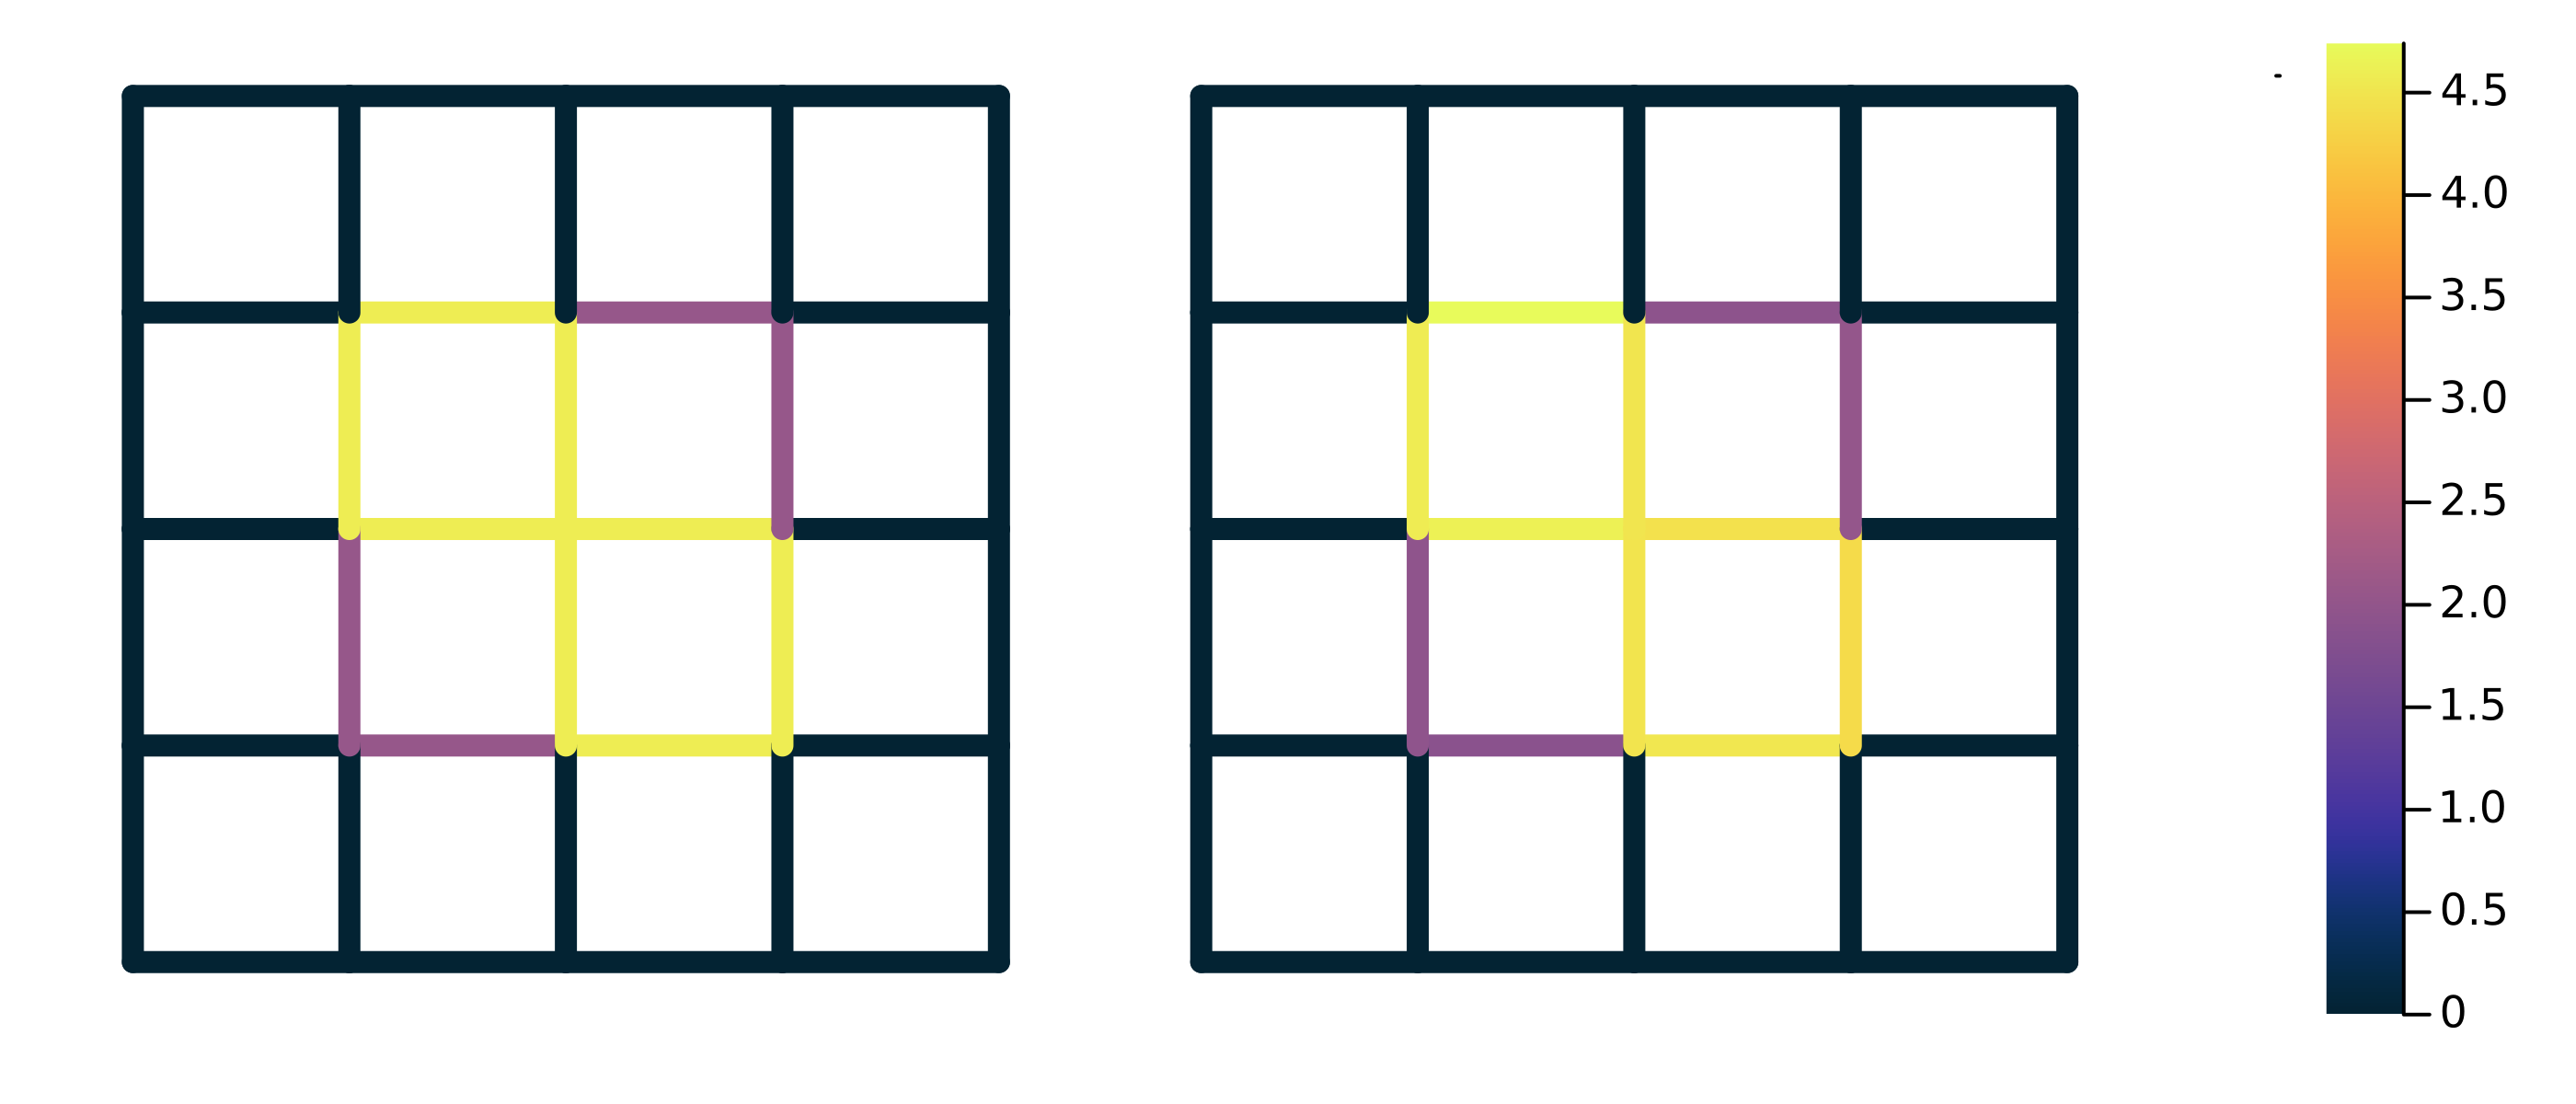

In [4]:
function plot_edge_quantity(f;lw=6,clims=extrema(f))
  p = plot()
  minf, maxf = clims
  for (i, r) in enumerate(eachrow(∇))
    i1, i2 = findall(abs.(r) .> 0)
    if (maxf-minf)/(maxf+minf) < 1e-6
      c = "black"
    else
      c = get(cgrad(:thermal),(f[i]-minf)/(maxf-minf))
    end
    plot!(p,[x[i1], x[i2]], [y[i1], y[i2]], linecolor=c, lw=lw)
  end
  plot!(p,legend=:none, aspect_ratio=:equal, axis=false, grid=false)
  return p
end
l = @layout [ grid(1,2) a{0.1w} ]; dpi=400; h=1*dpi; cw = h/4;
clims = extrema([edgemask.*deter;edgemask.*stoch])

# Colorbar
h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=clims,
                 xlims=(1,1.1), label="", c=:thermal, framestyle=:none,
                 size=(cw,h),dpi=dpi)

p1 = plot_edge_quantity(edgemask.*deter,lw=6,clims=clims);
plot!(p1,size=(h,h),dpi=dpi)
p2 = plot_edge_quantity(edgemask.*stoch,lw=6,clims=clims);
plot!(p2,size=(h,h),dpi=dpi)

# output
savefig(p1,"deter.png")
savefig(p2,"stoch.png")
savefig(h2,"thermal_noise_cbar.png")
p = plot(p1,p2,h2, layout=l,size=(700,300))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*